# Repsol Stock Data Analysis 📈

## **Objective:**
- Explore and visualize 20 years of Repsol stock data.
- Understand trends, volume, and price changes.
- Later → Predict closing price using models.

**Dataset Source:**
[Kaggle - Repsol Stock Data (20 Years)](https://www.kaggle.com/datasets/lucastrenzado/repsol-stock-data-20-years/data)

**My Kaggle Account:** 
[Kaggle - Account Link](https://www.kaggle.com/ctrlsari)

---
### **Importing libraries and local csv file**
---

In [143]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('RepsolStockData20Years.csv')

In [144]:
# Making sure the date column is datetime format
df['date'] = pd.to_datetime(df['date'])
# Making sure data is in chronological order
df.sort_values('date', inplace=True)

# Checking data types, nulls, stats, and if there are any missing values
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5093 entries, 0 to 5092
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5093 non-null   datetime64[ns]
 1   open    5093 non-null   float64       
 2   High    5093 non-null   float64       
 3   low     5093 non-null   float64       
 4   close   5093 non-null   float64       
 5   volume  5093 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 238.9 KB


date      0
open      0
High      0
low       0
close     0
volume    0
dtype: int64

---
### **Observations:**
---

##### 1️⃣ **Closing Price Trend Over 20 Years:**
- The closing price saw a significant increase from the early 2000s, peaking before the 2008 financial crisis.
- After 2008, there was a general decline, followed by fluctuations, but the stock has not recovered to its pre-2008 peak levels.
- Overall, the trend shows cyclical increases and decreases, but each upward trend becomes weaker over time, indicating a long-term weakening.


#### 2️⃣ **Noticeable Peaks/Drops:**
- Major peak: Around 2006-2008, coinciding with global market highs before the financial crisis.
- Major drop: Post-2008 crash, with another noticeable drop around 2012 and 2020 (this one is possibly linked to the COVID-19 pandemic affecting global markets).


#### 3️⃣ **Correlation Between Open/High/Low/Close/Volume:**
- **Open, High, Low, and Close prices** are perfectly correlated (**correlation = 1**) — as expected, since they reflect daily price movement in tandem.
- **Volume shows very weak correlation (~0.09) with price features,** meaning the number of shares traded doesn't strongly influence price changes in this dataset.
- **Date has a negative correlation (~ -0.61) with prices,** indicating a general long-term decrease over time the past 20 years. 


#### 4️⃣ **Volume Spikes:**
- Several volume spikes are noticeable, particularly around **2012 and post-2015**.
- These spikes could be linked to company events, market corrections, or broader economic events.
- However, volume data appears irregular and unpredictable, with no strong correlation to price behavior.


#### 5️⃣ **Distribution of Closing Prices:**
- The majority of closing prices fall between **€10 and €20**, with a clear peak around **€13–€17**.
- The distribution is **right-skewed**, meaning high closing prices (about €25–€30) are less frequent and could be outliers or rare spikes.
- This suggests that Repsol's stock price tends to stay within a stable range for most of the time, with occasional price surges.


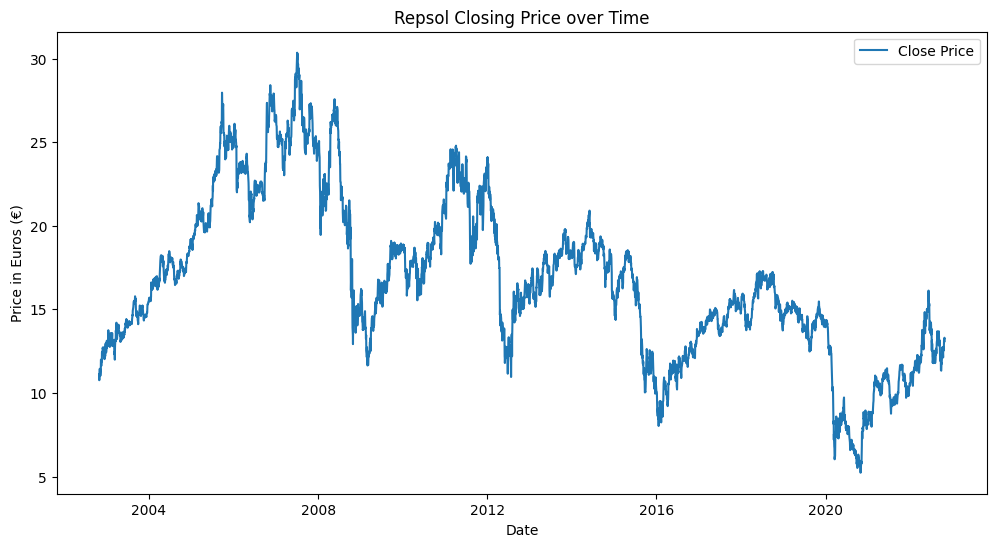

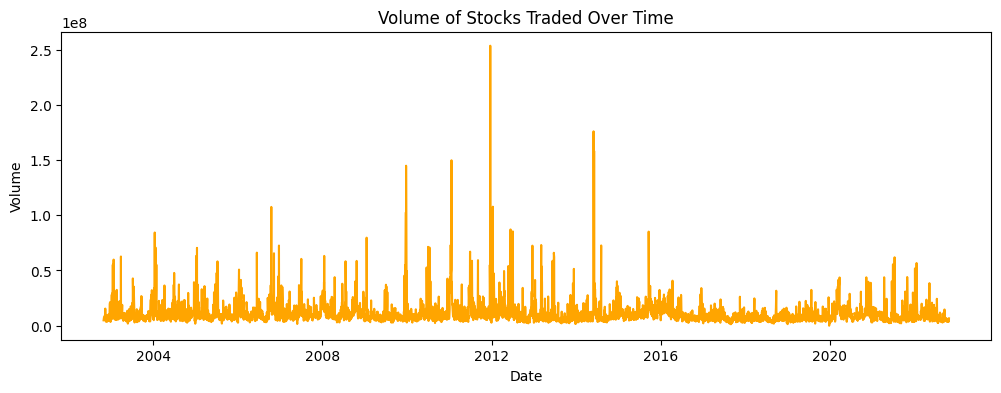

In [145]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label = 'Close Price')
plt.title('Repsol Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price in Euros (€)')
plt.legend()
plt.show

plt.figure(figsize=(12,4))
plt.plot(df['date'], df['volume'], color='orange')
plt.title('Volume of Stocks Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

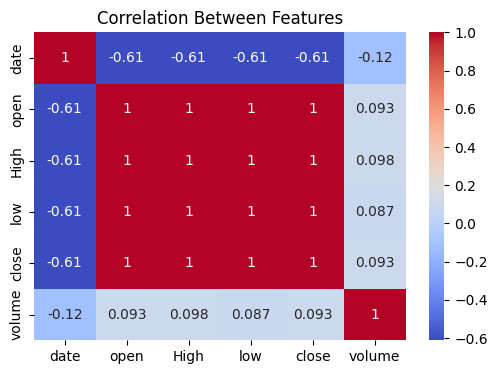

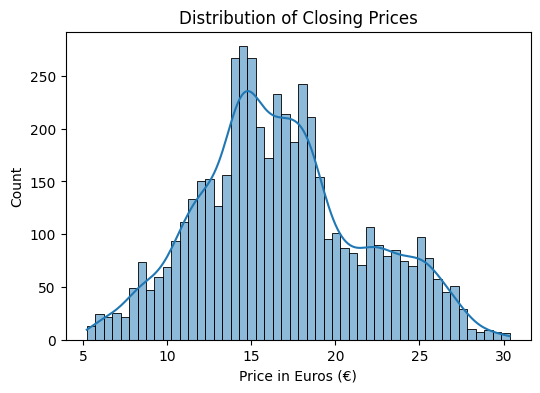

In [146]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price in Euros (€)')
plt.show()

---

### **Feature Engineering ✨**

To improve model performance and give more context about stock behavior, we will apply several feature engineering techniques:

---

#### 1️⃣ **Moving Averages (MA)**

**What is it?**
- Moving Average smooths out short-term fluctuations by averaging closing prices over a specific window of days.

**Why use it?**
- Helps detect long-term trends and removes daily price noise.

**Application:**
We will calculate:
- 7-Day Moving Average → Captures short-term trends.
- 30-Day Moving Average → Captures long-term trends.


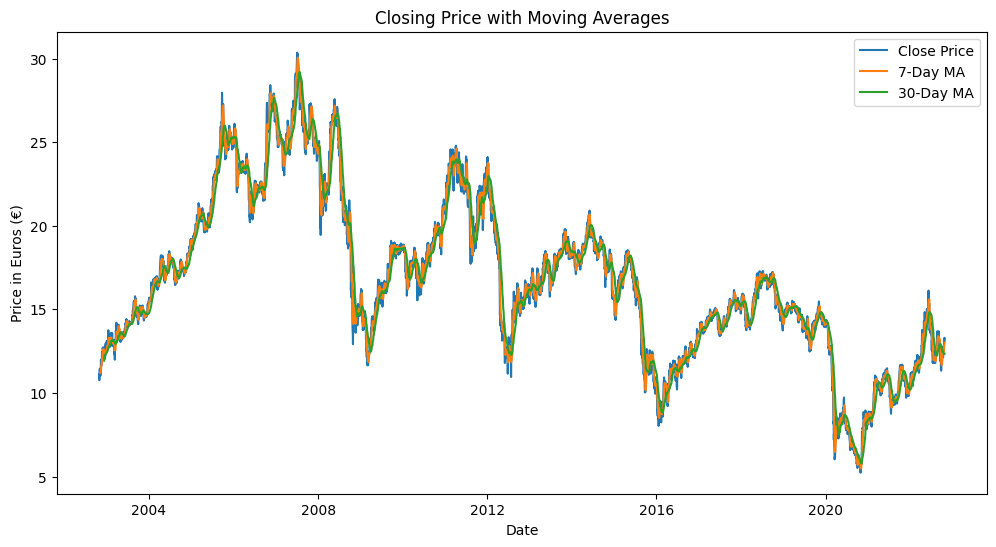

In [147]:
df['MA7'] = df['close'].rolling(window=7).mean() #7-day moving average
df['MA30'] = df['close'].rolling(window=30).mean() #30-Day moving average

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.plot(df['date'], df['MA7'], label='7-Day MA')
plt.plot(df['date'], df['MA30'], label='30-Day MA')
plt.xlabel('Date')
plt.ylabel('Price in Euros (€)')
plt.legend()
plt.title('Closing Price with Moving Averages')
plt.show()

---

#### 2️⃣ **Lag Feature (Previous Day Close)**

**What is it?**
- Uses the previous day's closing price as a feature for today's price.

**Why use it?**
- Stock prices depend heavily on past values, so giving the model yesterday's price can improve predictions.


In [148]:
df['Prev_Close'] = df['close'].shift(1)

---

#### 3️⃣ **Daily Percentage Change (Volatility Indicator)**

**What is it?**
- Calculates day-to-day percentage change in closing price.

**Why use it?**
- Captures volatility and shows how much the stock price jumps each day.


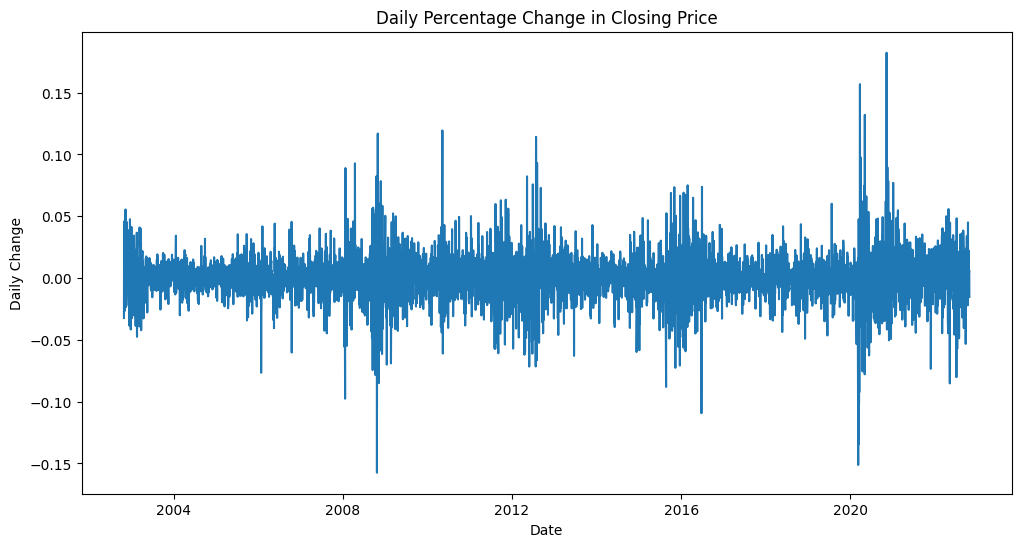

In [149]:
df['Daily_Change'] = df['close'].pct_change()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['Daily_Change'])
plt.title('Daily Percentage Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Daily Change')
plt.show()

---

#### 4️⃣ **Rolling Standard Deviation (Volatility Measure)**

**What is it?**
- Calculates standard deviation of closing price over a 7-day window to measure volatility.

**Why use it?**
- Shows periods of high/low volatility, which could impact stock behavior.


In [150]:
df['Rolling_STD_7'] = df['close'].rolling(window=7).std()

---

### **Predictive Modeling: Linear Regression 📈**

In this section, we'll build a baseline model using **Linear Regression** to predict Repsol's closing stock price based on the engineered features.

---

#### 1️⃣ **Model Choice: Why Linear Regression?**

**Reason:**
- Linear Regression is a simple, interpretable model.
- It helps establish a baseline performance.
- Works well when features have linear relationships to the target, and is easy to understand.

#### 2️⃣ **Selecting Features**

In [151]:
df.dropna(inplace=True)
features = ['MA7', 'MA30', 'Prev_Close', 'Daily_Change', 'Rolling_STD_7']
target = ['close']

X = df[features]
y = df[target]

#### 3️⃣ **Train-Test Split:**
- We split the data into 80% training and 20% testing.
- **Important:** Since this is time series data, we **avoid shuffling** to maintain chronological order.

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #80% is train, 20% is test

#### 4️⃣ **Model Training:**

In [153]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

#### 5️⃣ **Evaluation Metrics:**

We evaluated the model using three key metrics:

| Metric        | Value    | Interpretation                                           |
|--------------|---------:|-----------------------------------------------------------|
| **R² Score**  | 0.9955   | Explains 99.5% of the variance in closing price: excellent fit. |
| **RMSE**      | 0.1850   | On average, predictions deviate by about 18 cents from actual price. |
| **MAE**       | 0.0999   | Average absolute error is about 10 cents, indicating high precision. |


In [154]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R² Score'],
    'Score': [rmse, mae, r2]
})

print(metrics)


     Metric     Score
0      RMSE  0.185054
1       MAE  0.099909
2  R² Score  0.995531


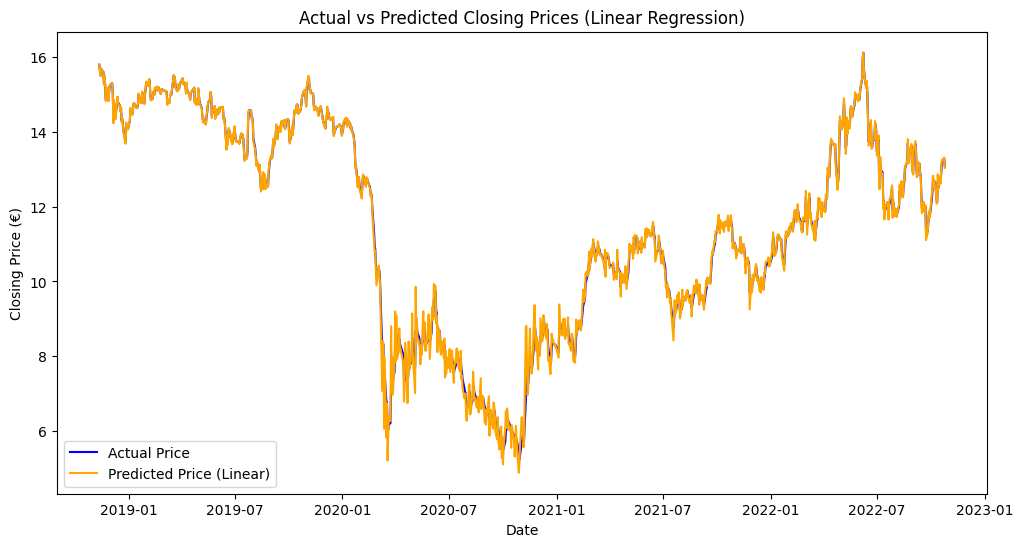

In [155]:
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(df['date'].iloc[-len(y_test):], y_pred, label='Predicted Price (Linear)', color='orange')
plt.xlabel('Date')
plt.ylabel('Closing Price (€)')
plt.title('Actual vs Predicted Closing Prices (Linear Regression)')
plt.legend()
plt.show()

In [156]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)


In [157]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest RMSE: 0.6948175855582094
Random Forest MAE: 0.2819329455873071
Random Forest R^2 Score: 0.9370022196815379


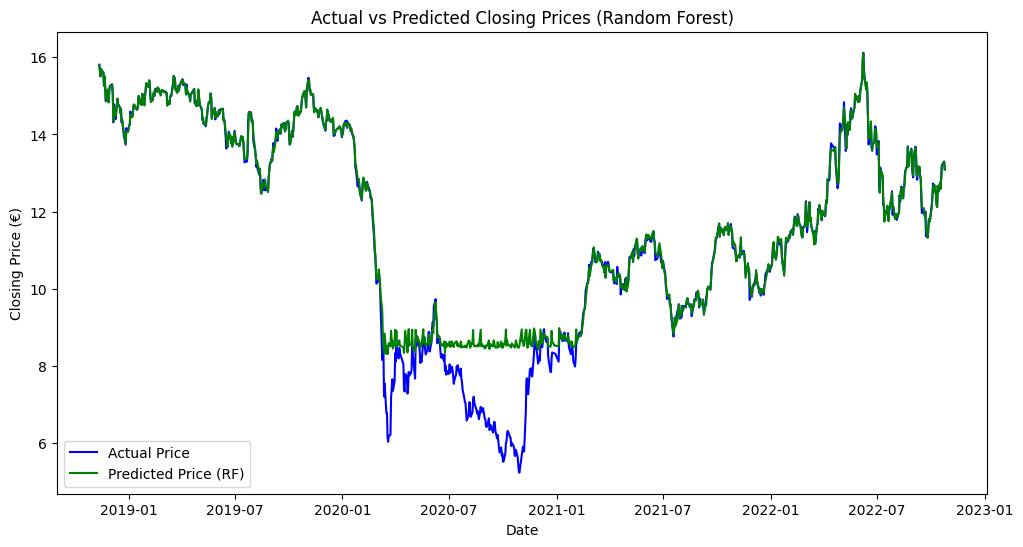

In [159]:
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(df['date'].iloc[-len(y_test):], y_pred_rf, label='Predicted Price (RF)', color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price (€)')
plt.title('Actual vs Predicted Closing Prices (Random Forest)')
plt.legend()
plt.show()
